In [1122]:
import pandas as pd
import matplotlib.pyplot as plt
from libemg.feature_extractor import FeatureExtractor
from libemg.offline_metrics import OfflineMetrics
from libemg.filtering import Filter
import matplotlib.pyplot as plt
import libemg
from libemg.feature_extractor import FeatureExtractor
from libemg.utils import get_windows
import time
import pywt
from scipy.signal import stft
from scipy.signal import resample
import numpy as np
from scipy.signal import welch

In [1123]:
fs =2148
filt_fs = 2148

In [1124]:
window_size =300
window_SHift = 150

In [1125]:
df = pd.read_csv('Data Cleaning/Subject-1/Trial_1.csv')

In [1126]:
import numpy as np


class Extractor:
    def __init__(self, signal, fs=1):
        self.signal = np.array(signal)
        self.fs = fs  # Sampling frequency


    def instantaneous_median_frequency_and_mean_power_frequency(self, windows, wavelet='cmor', level=2):
        imdf_values = []
        impf_values = []

        for window in windows:
            # Ensure the window is a 1D array for CWT
            if window.ndim > 1:
                window = window.flatten()

            # Generate scales based on the desired level
            scales = np.arange(1, 100)  # Adjust the range according to your needs

            # Perform Continuous Wavelet Transform (CWT) on the current window
            coefficients, frequencies = pywt.cwt(window, scales, wavelet, sampling_period=1/self.fs)
            
            # Calculate the power spectrum (magnitude squared of the complex coefficients)
            power_spectrum = np.abs(coefficients) ** 2

            # Calculate frequency weighted by power spectrum
            weighted_frequencies = frequencies[:, None] * power_spectrum

            # Sum power across all scales at each time point
            power_spectrum_sum = np.sum(power_spectrum, axis=0)
            weighted_frequencies_sum = np.sum(weighted_frequencies, axis=0)

            # Prevent division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                impf = np.nan_to_num(weighted_frequencies_sum / power_spectrum_sum)

            # Calculate Instantaneous Mean Power Frequency (IMPF)
            impf_value = np.mean(impf)  # Mean of weighted frequencies

            # Calculate Instantaneous Median Frequency (IMDF)
            imdf_value = np.median(impf)  # Median of weighted frequencies

            imdf_values.append(imdf_value)
            impf_values.append(impf_value)

        return imdf_values, impf_values

In [1127]:
def downsample_signal(df, original_frequency, target_frequency):
    # Calculate the resampling ratio
    resampling_ratio = target_frequency / original_frequency

    # Determine the new length of the resampled signal
    new_length = int(len(df) * resampling_ratio)

    # Resample the signal
    resampled_df =resample(df, new_length)

    return resampled_df

In [1128]:
class featureextractor:
    def __init__(self, signal, fs):
        self.signal = np.array(signal)
        self.fs = fs  # Sampling frequency

    def average_rectified_value(self, windows):
        features = [np.mean(np.abs(window)) for window in windows]
        return features

    def compute_stft(self, windows,):
        stft_results = []

        for window in windows:
            # Ensure the window is a 1D array
            if window.ndim > 1:
                window = window.flatten()

            ### Short-Time Fourier Transform (STFT) ###
            f_stft, t_stft, Zxx = stft(window, fs=self.fs, nperseg=window_size,noverlap=window_SHift)
            stft_results.append((f_stft, t_stft, Zxx))
        
        return stft_results

In [1129]:
def extract_features_from_stft(stft_results):
    features = []
    for f_stft, t_stft, Zxx in stft_results:
        # Convert STFT results to power spectrum
        power_spectrum = np.abs(Zxx)**2
        # Spectral centroid
        spectral_centroid = np.sum(f_stft[:, np.newaxis] * power_spectrum, axis=0) / np.sum(power_spectrum, axis=0)
        # Spectral bandwidth
        spectral_bandwidth = np.sqrt(np.sum(((f_stft[:, np.newaxis] - spectral_centroid)**2) * power_spectrum, axis=0) / np.sum(power_spectrum, axis=0))

        features.append(np.concatenate([spectral_centroid, spectral_bandwidth]))

    return np.array(features)

In [1130]:
def extract_features1(windows, target_fs):
    """
    Extract features from windows of signals.

    Parameters:
        windows (list of arrays): List of windows of signals.
        target_fs (int): Target sampling frequency.

    Returns:
        tuple of lists: Mean and mean power spectral density (PSD) for each window.
    """
    fmean = []
    fpsd = []

    for window in windows:
        # Calculate the mean of the window
        mean = np.mean(window)

        # Compute the power spectral density (PSD) of the window using Welch's method
        f, psd = welch(window, fs=target_fs,nperseg=window_size,noverlap=window_SHift)

        # Append the mean and mean of the PSD to the features lists
        fmean.append(mean)
        fpsd.append(np.mean(psd))

    return fmean, fpsd

In [1131]:
import pandas as pd

def replace_outliers_with_mean(dataframe, column_name):
    """
    Detects outliers in a specified column of a DataFrame and replaces them with the mean of the non-outlier values.

    Parameters:
    - dataframe: A pandas DataFrame containing the data.
    - column_name: The name of the column in which to detect and replace outliers.

    Returns:
    - The DataFrame with outliers in the specified column replaced by the mean of non-outliers.
    """
    # Calculate the first and third quartiles and the IQR
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers = (dataframe[column_name] < (Q1 - 1.5 * IQR)) | (dataframe[column_name] > (Q3 + 1.5 * IQR))

    # Calculate the mean of non-outliers
    mean_non_outliers = dataframe.loc[~outliers, column_name].mean()

    # Replace outliers with the mean of non-outliers
    dataframe.loc[outliers, column_name] = mean_non_outliers

    return dataframe


In [1132]:
# Get unique labels
unique_labels = df['Label'].unique()

# Create a dictionary to hold the DataFrames
dfs = {}

for label in unique_labels:
    # Filter the DataFrame based on the label and assign to a new DataFrame
    dfs[label] = df[df['Label'] == label]

In [1133]:
df_label_0 = dfs[0]
df_label_1 = dfs[1]
df_label_2 = dfs[2]
df_label_3 = dfs[3]

In [1134]:
df1 = df_label_0['EMG'].values
df2 = df_label_1['EMG'].values
df3 = df_label_2['EMG'].values
df4 = df_label_3['EMG'].values

In [1135]:
down1 = df1
down2 = df2
down3 = df3
down4 = df4


In [1136]:
fe = FeatureExtractor() #Defining the Feature extractor
feature_list= ['RMS','MAV','WL','ZC','MDF','MNF','MNP','SSC'] #List of required features

windows1 = get_windows(down1, window_size, window_SHift) # 180 is the window size and 36 is the slinding window size 
windows2 = get_windows(down2, window_size, window_SHift) # 180 is the window size and 36 is the slinding window size 
windows3 = get_windows(down3, window_size, window_SHift) # 180 is the window size and 36 is the slinding window size 
windows4 = get_windows(down4, window_size, window_SHift) # 180 is the window size and 36 is the slinding window size 


In [1137]:
features1 = fe.extract_features(feature_list, windows1) #this function will extract all the features 
features2 = fe.extract_features(feature_list, windows2) #this function will extract all the features 
features3 = fe.extract_features(feature_list, windows3) #this function will extract all the features 
features4 = fe.extract_features(feature_list, windows4) #this function will extract all the features 

In [1138]:
extractors1 = Extractor(windows1,fs)

imdf_feature1,impf_feature1= extractors1.instantaneous_median_frequency_and_mean_power_frequency(windows1,'cmor1.5-1.0')

extractors2 = Extractor(windows2,fs)

imdf_feature2,impf_feature2= extractors2.instantaneous_median_frequency_and_mean_power_frequency(windows2,'cmor1.5-1.0')

extractors3 = Extractor(windows3,fs)

imdf_feature3,impf_feature3= extractors3.instantaneous_median_frequency_and_mean_power_frequency(windows3,'cmor1.5-1.0')

extractors4 = Extractor(windows4,fs)

imdf_feature4,impf_feature4= extractors4.instantaneous_median_frequency_and_mean_power_frequency(windows4,'cmor1.5-1.0')

In [1139]:
extractors1 = featureextractor(windows1,fs)
temp_feature1= extractors1.average_rectified_value(windows1)
stft_feature1= extractors1.compute_stft(windows1)

stft_features1 = extract_features_from_stft(stft_feature1)

# Creating feature names dynamically based on the number of features
stft_feature_names = [f'stft_feature_{i+1}' for i in range(stft_features1.shape[1])]

# Convert arrays to DataFrames
stft_df1 = pd.DataFrame(stft_features1, columns=stft_feature_names)

In [1140]:
extractors2 = featureextractor(windows2,fs)
temp_feature2= extractors2.average_rectified_value(windows2)
stft_feature2= extractors2.compute_stft(windows2)

stft_features2 = extract_features_from_stft(stft_feature2)

# Creating feature names dynamically based on the number of features
stft_feature_names = [f'stft_feature_{i+1}' for i in range(stft_features2.shape[1])]

# Convert arrays to DataFrames
stft_df2 = pd.DataFrame(stft_features2, columns=stft_feature_names)

In [1141]:
extractors3 = featureextractor(windows3,fs)
temp_feature3= extractors3.average_rectified_value(windows3)
stft_feature3= extractors3.compute_stft(windows3)

stft_features3 = extract_features_from_stft(stft_feature3)

# Creating feature names dynamically based on the number of features
stft_feature_names = [f'stft_feature_{i+1}' for i in range(stft_features3.shape[1])]

# Convert arrays to DataFrames
stft_df3 = pd.DataFrame(stft_features3, columns=stft_feature_names)

In [1142]:
extractors4 = featureextractor(windows4,fs)
temp_feature4= extractors4.average_rectified_value(windows4)
stft_feature4= extractors4.compute_stft(windows4)

stft_features4 = extract_features_from_stft(stft_feature4)

# Creating feature names dynamically based on the number of features
stft_feature_names = [f'stft_feature_{i+1}' for i in range(stft_features4.shape[1])]

# Convert arrays to DataFrames
stft_df4 = pd.DataFrame(stft_features4, columns=stft_feature_names)

In [1143]:
mean1,psd1 = extract_features1(windows1,fs)
mean2,psd2 = extract_features1(windows2,fs)
mean3,psd3 = extract_features1(windows3,fs)
mean4,psd4 = extract_features1(windows4,fs)

In [1144]:
# Flatten the arrays
data_flat1 = {key: value.flatten() for key, value in features1.items()}
data_flat2 = {key: value.flatten() for key, value in features2.items()}
data_flat3 = {key: value.flatten() for key, value in features3.items()}
data_flat4 = {key: value.flatten() for key, value in features4.items()}

processed_data1 = pd.DataFrame(data_flat1)
processed_data2 = pd.DataFrame(data_flat2)
processed_data3 = pd.DataFrame(data_flat3)
processed_data4 = pd.DataFrame(data_flat4)


In [1145]:
temp_data1 = pd.DataFrame({'IMDF': imdf_feature1,'IMPF': impf_feature1, 'PSD': psd1})
temp_data2 = pd.DataFrame({'IMDF': imdf_feature2,'IMPF': impf_feature2, 'PSD': psd2})
temp_data3 = pd.DataFrame({'IMDF': imdf_feature3,'IMPF': impf_feature3, 'PSD': psd3})
temp_data4 = pd.DataFrame({'IMDF': imdf_feature4,'IMPF': impf_feature4, 'PSD': psd4})

In [1146]:
# Concatenate existing DataFrame and new column DataFrame along the columns axis
processed_data1= pd.concat([processed_data1, temp_data1,stft_df1], axis=1)
processed_data2= pd.concat([processed_data2, temp_data2,stft_df2], axis=1)
processed_data3= pd.concat([processed_data3, temp_data3,stft_df3], axis=1)
processed_data4= pd.concat([processed_data4, temp_data4,stft_df4], axis=1)

In [1147]:
processed_data1['Label'] = 0
processed_data2['Label'] = 1
processed_data3['Label'] = 2
processed_data4['Label'] = 3

In [1148]:
combined_df1= pd.DataFrame()

In [1149]:
combined_df1 = pd.concat([processed_data1,processed_data2,processed_data3,processed_data4], axis=0)

In [1150]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Plot non Fatigue data
fig.add_trace(go.Scatter(x=combined_df1 [combined_df1 ['Label'] == 0].index, y=combined_df1 [combined_df1 ['Label'] == 0]['MNF'], mode='lines', name="Resting"))

# Plot Transition to Fatigue data
fig.add_trace(go.Scatter(x=combined_df1 [combined_df1 ['Label'] == 1].index, y=combined_df1 [combined_df1 ['Label'] == 1]['MNF'], mode='lines', name="No strain"))

# Plot Transition to Fatigue data
fig.add_trace(go.Scatter(x=combined_df1 [combined_df1 ['Label'] == 2].index, y=combined_df1 [combined_df1 ['Label'] == 2]['MNF'], mode='lines', name="medium strain"))

# Plot Fatigue data
fig.add_trace(go.Scatter(x=combined_df1 [combined_df1 ['Label'] == 3].index, y=combined_df1 [combined_df1 ['Label'] == 3]['MNF'], mode='lines', name="max strain"))



# Update layout
fig.update_layout(
    title="ARV Raw Signal",
    xaxis_title="Time",
    yaxis_title="Amplitude"
)

# Show plot
fig.show()


In [1151]:
combined_df1

,RMS,MAV,WL,ZC,MDF,MNF,MNP,SSC,IMDF,IMPF,PSD,stft_feature_1,stft_feature_2,stft_feature_3,stft_feature_4,stft_feature_5,stft_feature_6,Label
0,0.024689,0.024575,0.288250,0,0.000000,1.978236,0.000003,112,36.076207,36.385301,4.085700e-09,11.022312,2.088200,12.401491,47.845019,13.431052,52.752427,0
1,0.024756,0.024619,0.301527,0,0.000000,2.144382,0.000003,110,31.023329,32.000022,5.849076e-09,10.840300,2.237630,14.270892,47.025766,15.098338,56.141090,0
2,0.024634,0.024475,0.296306,0,0.000000,1.929353,0.000003,117,35.006006,35.349022,8.723401e-09,11.015236,2.197387,11.518562,49.590202,13.992923,49.390201,0
3,0.024495,0.024382,0.271317,0,0.000000,2.119196,0.000003,117,36.878572,37.767103,4.271371e-09,12.967579,2.031083,13.354197,55.315095,13.264009,57.786760,0
4,0.024646,0.024556,0.262096,0,0.000000,1.813759,0.000003,120,33.702712,36.789168,4.519850e-09,11.180677,2.188365,10.387517,47.906829,14.919196,42.173152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.067600,0.053240,2.694533,10,25.390625,27.332055,0.000016,55,40.602016,40.236761,3.962045e-06,80.763220,51.689006,18.634961,77.857081,39.049287,55.735843,3
295,0.041060,0.033808,1.190233,6,13.671875,14.471210,0.000007,62,38.582383,37.438355,1.437281e-07,52.169630,8.560924,23.587327,42.897877,27.665401,52.025378,3
296,0.030547,0.026906,0.934955,8,0.000000,9.403410,0.000004,60,40.540878,42.095919,2.048729e-07,19.152743,12.638474,33.904082,54.252160,32.683322,54.485357,3
297,0.028474,0.025419,0.776060,6,0.000000,9.425900,0.000004,69,42.495740,43.107197,3.834830e-07,24.798309,21.852739,14.685241,69.015123,40.301223,60.397818,3


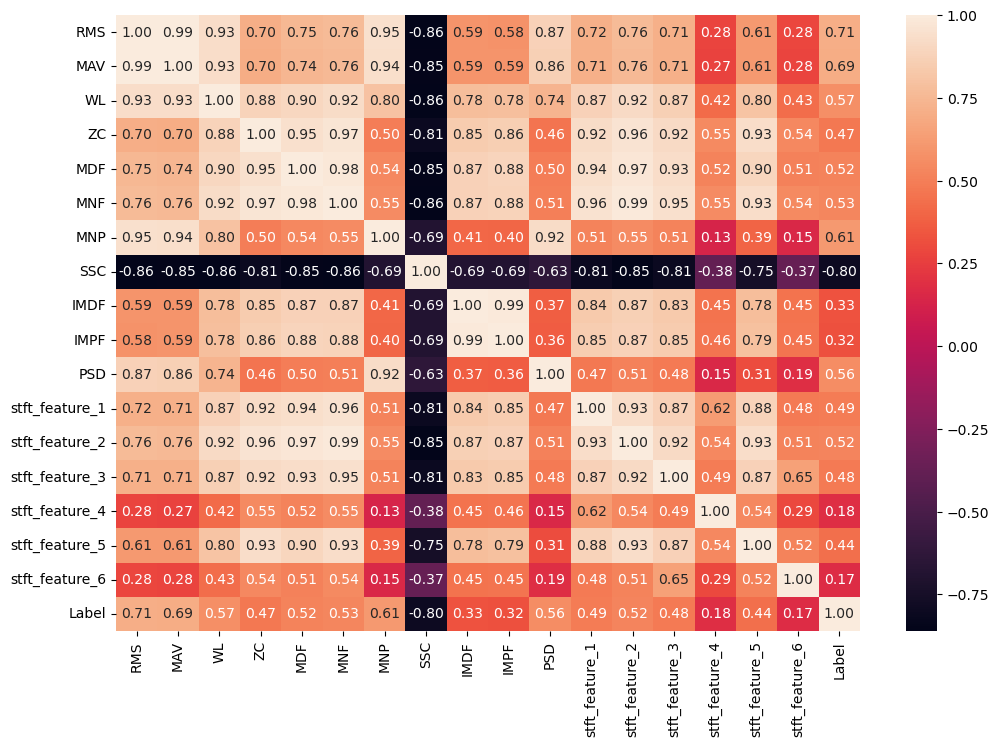

In [1152]:
import seaborn as sns

corr_matrix = combined_df1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [ ]:
file_name1 = 'Dataset1.csv'
final_folder_path1 = '/Extracted Feature Data/Subject-1'

In [ ]:
# Specify the folder path and file name
folder_path = final_folder_path1
# Save the DataFrame to CSV format in the specified location
combined_df1.to_csv(f'{folder_path}/{file_name1}', index=False)

# Print a message indicating the file has been saved
print(f'DataFrame saved to: {folder_path}/{file_name1}')

DataFrame saved to: F:/Dataset/Sarthak/Dataset8.csv
